In [1]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
from sklearn.model_selection import KFold
import copy

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user_embed = nn.Embedding(nb_users, mf_dim)
        self.mf_item_embed = nn.Embedding(nb_items, mf_dim)
        self.mlp_user_embed = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.mlp_item_embed = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        self.dropout = dropout
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList()
        for i in range(1, nb_mlp_layers):
            self.mlp.extend([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])])  
        self.final = nn.Linear(mlp_layer_sizes[-1] + mf_dim, 1)
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot
        self.mf_user_embed.weight.data.normal_(0., 0.01)
        self.mf_item_embed.weight.data.normal_(0., 0.01)
        self.mlp_user_embed.weight.data.normal_(0., 0.01)
        self.mlp_item_embed.weight.data.normal_(0., 0.01)
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        xmfu = self.mf_user_embed(user)
        xmfi = self.mf_item_embed(item)
        xmf = xmfu * xmfi

        xmlpu = self.mlp_user_embed(user)
        xmlpi = self.mlp_item_embed(item)
        xmlp = torch.cat((xmlpu, xmlpi), dim=1)
        for i, layer in enumerate(self.mlp):
            xmlp = layer(xmlp)
            xmlp = nn.functional.relu(xmlp)
            if self.dropout != 0:
                xmlp = nn.functional.dropout(xmlp, p=self.dropout, training=self.training)

        x = torch.cat((xmf, xmlp), dim=1)
        x = self.final(x)
        if sigmoid:
            x = torch.sigmoid(x)
        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [4]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this!
        #Sample neg users
        USER,ITEM=0,1
        neg_users = ratings[:,USER].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,USER], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,ITEM]).repeat(self.negative_samples).random_(0,max_item)
        self.items = torch.cat((ratings[:,ITEM], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,ITEM], dtype=torch.float32).repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,ITEM], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [5]:
optimizers = [optim.SGD, optim.Adam, optim.RMSprop]
str(optimizers[0])

"<class 'torch.optim.sgd.SGD'>"

In [6]:
users_num = 943 + 1
movies_num = 1682 + 1
k_folds = 5

ds_train = ML100kDataset('ml-100k/u1.base', 2)
# ds_test = ML100kDataset('ml-100k/u1.test',2)

# Perform cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)


optimizers = [optim.SGD, optim.Adam, optim.RMSprop]
# optimizers = [optim.SGD]

oprtimizer_test_loss ={}

for optimizer_class in optimizers:
    test_loss = []
    train_loss = []
    for fold, (train_index, test_index) in enumerate(kf.split(ds_train)):
        print(f"Fold {fold+1}/{k_folds}")

        train_fold = torch.utils.data.Subset(ds_train, train_index)
        test_fold = torch.utils.data.Subset(ds_train, test_index)

        train_dl = DataLoader(train_fold, batch_size=16*1024, shuffle=True)
        test_dl = DataLoader(test_fold, batch_size=16*1024, shuffle=False)

        model = NeuMF(users_num, movies_num, 16, [128, 64, 32])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        optimizer = optimizer_class(model.parameters(), lr=0.001)

        fold_test_loss = []
        fold_train_loss = []

        for epoch in range(20):
            model.train()
            tr_loss = []
            print("Training " + str(epoch))
            for (u, i, l) in tqdm.tqdm(train_dl):
                optimizer.zero_grad()
                yhat = model(u, i, sigmoid=True)
                l = l.unsqueeze(1)
                loss = criterion(yhat, l)
                tr_loss.append(loss.item())
                loss.backward()
                optimizer.step()
            fold_train_loss.append(np.mean(tr_loss))

            model.eval()
            predictions = []
            with torch.no_grad():
                t_loss = []
                for i, (u, i, l) in enumerate(test_dl):
                    yhat = model(u, i, sigmoid=True)
                    predictions.append(yhat)
                    l = l.unsqueeze(1)
                    tl = criterion(yhat, l)
                    t_loss.append(tl.item())
                fold_test_loss.append(np.mean(t_loss))


        train_loss.append(fold_train_loss)
        test_loss.append(fold_test_loss)

    train_loss = np.array(train_loss)
    test_loss = np.array(test_loss)

    last_test_loss = test_loss[:, -1]
    last_train_loss = train_loss[:, -1]


    mean_train_loss = np.mean(last_train_loss, axis=0)
    mean_test_loss = np.mean(last_test_loss, axis=0)
    std_train_loss = np.std(last_train_loss, axis=0)
    std_test_loss = np.std(last_test_loss, axis=0)
    
    oprtimizer_test_loss[str(optimizer_class)] = mean_test_loss

    print("Mean Train Loss:", mean_train_loss)
    print("Mean Test Loss:", mean_test_loss)
    print("Std Train Loss:", std_train_loss)
    print("Std Test Loss:", std_test_loss)

Fold 1/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.09it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.26it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.30it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.16it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.23it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.19it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.14it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.29it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.18it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.37it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.22it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.17it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.42it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.26it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.14it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.29it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.28it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.16it/s]


Fold 2/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.21it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.32it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.22it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.26it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.18it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.23it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.35it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.26it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.31it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.23it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.40it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.32it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.22it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.48it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.36it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.32it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.37it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.43it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.39it/s]


Fold 3/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.28it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.23it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.32it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.21it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.29it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.18it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.27it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.31it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.27it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.27it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.32it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.43it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.35it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.28it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.40it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.28it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.34it/s]


Fold 4/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.42it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.27it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.28it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.30it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.36it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.36it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.29it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.33it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.23it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.30it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.23it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.41it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.26it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.48it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.29it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.36it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.49it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.31it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.29it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.32it/s]


Fold 5/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.30it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.41it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.37it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.26it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.27it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.23it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.33it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.27it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.30it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.30it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.30it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.41it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.34it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.34it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.42it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.32it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.31it/s]


Mean Train Loss: 0.6848308652639389
Mean Test Loss: 0.6839955766995749
Std Train Loss: 0.012578877049909662
Std Test Loss: 0.013429724650044843
Fold 1/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.30it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.28it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.50it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.38it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.26it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.06it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.31it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.21it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.27it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.38it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.33it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.21it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.40it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.29it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.38it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.34it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.16it/s]


Fold 2/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.28it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.32it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.13it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.17it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.29it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.31it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.31it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.23it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.28it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.28it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.32it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.57it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.28it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.31it/s]


Fold 3/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.08it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.21it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.32it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.52it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.32it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.39it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.38it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.28it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.87it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.02it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.14it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.04it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.08it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.00it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.11it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.11it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.68it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.92it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.05it/s]


Fold 4/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.38it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.21it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.23it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.18it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.07it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.38it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.97it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.14it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.11it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.98it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.12it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.12it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.07it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.13it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.23it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.27it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.30it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.27it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.06it/s]


Fold 5/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.04it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.01it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.13it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.08it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.26it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.99it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.17it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.03it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.06it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.93it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.84it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.14it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.97it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.16it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.10it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.06it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.02it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.22it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.04it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Mean Train Loss: 0.4458847348888715
Mean Test Loss: 0.46609019835790005
Std Train Loss: 0.0010927241506597548
Std Test Loss: 0.0014501169386067357
Fold 1/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.26it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.10it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.45it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.22it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.18it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.02it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.11it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.09it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.96it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.05it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.80it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.15it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.13it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.02it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.87it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.88it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.05it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.07it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.14it/s]


Fold 2/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.33it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.18it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.13it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.36it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.14it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.27it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.37it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.95it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.96it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.97it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.10it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.22it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.99it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.62it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.07it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.01it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.55it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.96it/s]


Fold 3/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.94it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.63it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.47it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.17it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.74it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.72it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.71it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.12it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.09it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.88it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.06it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.89it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.99it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.05it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.02it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.21it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.21it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.21it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.16it/s]


Fold 4/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.57it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.17it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.40it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.82it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.09it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.86it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.75it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.19it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.20it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.27it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.33it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.16it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.22it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.08it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.65it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.09it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Fold 5/5
Training 0


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.05it/s]


Training 1


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.09it/s]


Training 2


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.20it/s]


Training 3


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.24it/s]


Training 4


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.21it/s]


Training 5


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.44it/s]


Training 6


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.58it/s]


Training 7


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.97it/s]


Training 8


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.04it/s]


Training 9


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.83it/s]


Training 10


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.92it/s]


Training 11


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.89it/s]


Training 12


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.85it/s]


Training 13


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.45it/s]


Training 14


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.68it/s]


Training 15


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.91it/s]


Training 16


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.48it/s]


Training 17


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.63it/s]


Training 18


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.59it/s]


Training 19


100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.47it/s]


Mean Train Loss: 0.417243567109108
Mean Test Loss: 0.45259682337443036
Std Train Loss: 0.0020957974502329056
Std Test Loss: 0.0024732028693725695


In [7]:
oprtimizer_test_loss

{"<class 'torch.optim.sgd.SGD'>": 0.6839955766995749,
 "<class 'torch.optim.adam.Adam'>": 0.46609019835790005,
 "<class 'torch.optim.rmsprop.RMSprop'>": 0.45259682337443036}

In [12]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
users_num = 943 + 1
movies_num = 1682 + 1

ds_train = ML100kDataset('ml-100k/u1.base',2)
ds_test = ML100kDataset('ml-100k/u1.test',2)
# create a data loader for train and test sets
train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)
model = NeuMF(users_num,movies_num,16,[128,64,32])
criterion = nn.BCELoss()
# optimizer = Adam(model.parameters(), lr=0.001)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
test_loss = []
train_loss = []
for epoch in range(20):
    model.train()
    tr_loss=[]
    print("Traininng "+str(epoch))
    for (u,i,l) in tqdm.tqdm(train_dl):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(u,i,sigmoid=True)
        l = l.unsqueeze(1)
        # calculate loss
        loss = criterion(yhat, l)
        tr_loss.append(loss.detach().numpy())
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
    train_loss.append(np.mean(tr_loss))
    model.eval()
    predictions = []
    with torch.no_grad():
        t_loss=[]
        for i, (u,i,l) in enumerate(test_dl):
            yhat = model(u, i, sigmoid=True)
            predictions.append(yhat)
            l = l.unsqueeze(1)
            tl = criterion(yhat, l)
            t_loss.append(tl) 
        test_loss.append(np.mean(t_loss))

Traininng 0


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.41it/s]


Traininng 1


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.48it/s]


Traininng 2


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.38it/s]


Traininng 3


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.42it/s]


Traininng 4


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.53it/s]


Traininng 5


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.53it/s]


Traininng 6


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.41it/s]


Traininng 7


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.49it/s]


Traininng 8


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.57it/s]


Traininng 9


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.30it/s]


Traininng 10


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.71it/s]


Traininng 11


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.49it/s]


Traininng 12


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.63it/s]


Traininng 13


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.51it/s]


Traininng 14


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.65it/s]


Traininng 15


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.62it/s]


Traininng 16


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.56it/s]


Traininng 17


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.41it/s]


Traininng 18


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.52it/s]


Traininng 19


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.71it/s]


### Plot results

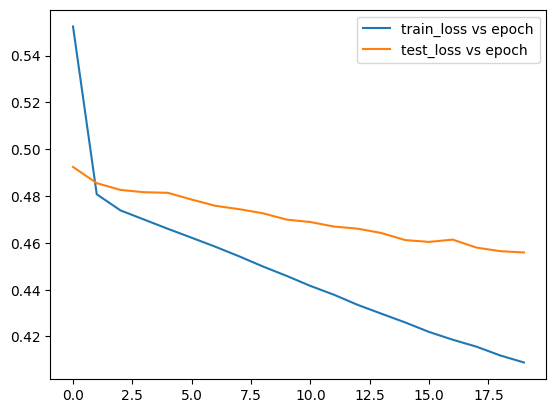

In [13]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.show()

### Your task
1. Find best HP of the model by crossvalidation
2. for every user provide the recommendation, calculate HR@10 (as in the previous excersise)